In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from numpy import asarray
from tensorflow.keras.layers import Input,Embedding,GRU,MaxPooling2D,GlobalMaxPooling2D,Bidirectional
from tensorflow.keras.layers import LSTM,Concatenate,MaxPool1D,Flatten,Dropout,Masking,Softmax,Dense,Embedding
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TerminateOnNaN,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.models import Sequential
#BPEmb is set of pretrained vectors like glove vectors
from bpemb import BPEmb
from tqdm import tqdm

### Importing Data

In [2]:
#Importing Dataset
DfTrain = pd.read_pickle('PreProcessed\WordLevelTrainingData.pkl')
DfVal = pd.read_pickle('PreProcessed\WordLevelValidationData.pkl')
DfTest = pd.read_pickle('PreProcessed\WordLevelTestingData.pkl')

#Merging DataFrames for more Corpus
AllData = pd.concat([DfTrain,DfVal,DfTest])
AllData.head()

,X,Y
0,hey handsome fellas i am thinking about coming...,nipsco next week
1,we need the two gas,agreements to get it all nailed down
2,the generators say,their prices were fair based on market conditions
3,thanks again for all of,your advice
4,contracts that mention the pony express,extension


In [3]:
AllData.shape

(1887787, 2)

### Checking Data

In [4]:
bpemb_en = BPEmb(lang="en",vs=50000)

In [5]:
#As we discussed in the previous steps , we are only having words with more than 14 words
#There for excluding other words. 1 and 2 indicates spaces there fore setting 16 as limit
dataEncoding = bpemb_en.encode_ids_with_bos_eos(AllData['X'].values+' '+AllData['Y'].values)

In [6]:
lenBadWords = 0
indexList = []
for i,ele in enumerate(dataEncoding):
    if len(ele) > 16:
        lenBadWords += 1
        indexList.append(i)
lenBadWords

142703

In [7]:
#Deleting bad Data
AllData.drop(AllData.index[indexList],inplace=True)
AllData.shape

(1646352, 2)

### Splitting the Dataset

In [8]:
#Creating New Decoder Column as Y_Dec
AllData['Y_Dec'] = AllData['Y'].copy()
AllData.head(2)

,X,Y,Y_Dec
1,we need the two gas,agreements to get it all nailed down,agreements to get it all nailed down
2,the generators say,their prices were fair based on market conditions,their prices were fair based on market conditions


In [9]:
encInput = np.array(AllData['X'])
decInput = np.array(AllData['Y'])
decOutput = np.array(AllData['Y_Dec'])

In [10]:
encInpTrain, encInpTest, decInpTrain, decInpTest, decOutTrain, decOutTest = train_test_split(encInput, decInput,decOutput, test_size=0.3,random_state=42)

In [30]:
encInpTrainText, encInpTestText, decInpTrainText, decInpTestText, decOutTrainText, decOutTestText = train_test_split(encInput, decInput,decOutput, test_size=0.3,random_state=42)

In [11]:
#Lengths
print('-'*5,'Training Data Length','-'*5)
print(len(encInpTrain),'    ',len(decInpTrain),'    ',len(decOutTrain))
print('\n','-'*5,'Testing Data Length','-'*5)
print(len(encInpTest),'    ',len(decInpTest),'    ',len(decOutTest))

----- Training Data Length -----
1152446      1152446      1152446

 ----- Testing Data Length -----
493906      493906      493906


### Text Encoding

In [17]:
#Freeing some space
del AllData
del DfTrain
del DfVal
del DfTest

In [12]:
encInpTrain = bpemb_en.encode_ids_with_bos_eos(encInpTrain)
encInpTest = bpemb_en.encode_ids_with_bos_eos(encInpTest)
print('-'*5,'Encoding Completed for Encoder input data','-'*5)

decInpTrain = bpemb_en.encode_ids_with_bos_eos(decInpTrain)
decInpTest = bpemb_en.encode_ids_with_bos_eos(decInpTest)
print('-'*5,'Encoding Completed for Decoder input data','-'*5)

decOutTrain = bpemb_en.encode_ids_with_eos(decOutTrain)
decOutTest = bpemb_en.encode_ids_with_eos(decOutTest)
print('-'*5,'Encoding Completed for Decoder output data','-'*5)

print('Enco Done')
def max_length(t):
    return max(len(i) for i in t)

max_length_in = max_length(encInpTrain)
max_length_out = max_length(decInpTrain)
ultra_max = max(max_length_in,max_length_out)
print('max length Encoder',max_length_in)
print('max length Decoder',max_length_out)
#Taking only 1 max value so we dont run into problem of same output in concat layer
print('max ',ultra_max)

encInpTrain = pad_sequences(encInpTrain, maxlen=ultra_max, padding="post")
decInpTrain = pad_sequences(decInpTrain, maxlen=ultra_max, padding="post")
decOutTrain = pad_sequences(decOutTrain, maxlen=ultra_max, padding="post")
print('-'*5,'Padding Completed for encoder data','-'*5)

encInpTest = pad_sequences(encInpTest, maxlen=ultra_max, padding="post")
decInpTest = pad_sequences(decInpTest, maxlen=ultra_max, padding="post")
decOutTest = pad_sequences(decOutTest, maxlen=ultra_max, padding="post")
print('-'*5,'Encoding Completed for Decoder data','-'*5)


----- Encoding Completed for Encoder input data -----
----- Encoding Completed for Decoder input data -----
----- Encoding Completed for Decoder output data -----
Enco Done
max length Encoder 15
max length Decoder 13
max  15
----- Padding Completed for encoder data -----
----- Encoding Completed for Decoder data -----


### Training Model without Attention

In [93]:
inputEncoder = Input(shape = (ultra_max,))
embedding_encoder = Embedding(bpemb_en.vectors.shape[0],100,embeddings_initializer = tf.keras.initializers.Constant(bpemb_en.vectors), input_length=ultra_max,trainable=False)
gru_en = GRU(units = 64, return_sequences = True, return_state = True)
gru_bi_encoder = Bidirectional(gru_en)

#Decoder
inputDecoder = Input(shape=(None,))
embedding_decoder = Embedding(bpemb_en.vectors.shape[0],100,embeddings_initializer = tf.keras.initializers.Constant(bpemb_en.vectors), input_length=ultra_max,trainable=False)
gru_de = GRU(units = 128, return_sequences = True, return_state = True)

#create model flow
#encoder flow
input_en = inputEncoder
embEnc = embedding_encoder(input_en)
encoder_out, forward_state, backward_state = gru_bi_encoder(embEnc)
state_h = tf.keras.layers.Concatenate()([forward_state, backward_state])

#decoder flow
input_de = inputDecoder
embDec = embedding_decoder(input_de)
decoder_out, _ = gru_de(embDec, initial_state=state_h)

dropout = Dropout(0.3)(decoder_out)
dense = tf.keras.layers.Dense(32, activation="relu",kernel_initializer = tf.keras.initializers.HeNormal())(dropout)
dropout = Dropout(0.3)(dense)

decoderOutput = tf.keras.layers.Dense(bpemb_en.vectors.shape[0], activation="softmax")(dropout)

In [94]:
filepath="model2_save/weights-{epoch:02d}-{val_perplexity:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_perplexity', save_best_only=True, mode='min')

earlystop = EarlyStopping(monitor='val_perplexity', patience=10,min_delta=0.001,mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.01, patience=3, min_lr=0.001)
callbacks_list = [checkpoint,earlystop,reduce_lr]

In [13]:
def perplexity(y_true, y_pred):
    '''
    Returns Perplexity
    '''
    SparseCrossEnt = tf.keras.backend.sparse_categorical_crossentropy(y_true, y_pred)
    return tf.keras.backend.exp(tf.keras.backend.mean(SparseCrossEnt))

In [96]:
# Define the model that uses the Encoder and the Decoder
model = Model([inputEncoder, inputDecoder], decoderOutput)

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy',perplexity])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 100)      5000000     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 15, 128),    63744       ['embedding[0][0]']              
                                 (None, 64),                                                  

In [97]:
History = model.fit([encInpTrain, decInpTrain], decOutTrain,batch_size=70,epochs=50,validation_split=0.2,callbacks = callbacks_list)

Epoch 1/50
13171/13171 [==============================] - 1236s 91ms/step - loss: 2.0038 - accuracy: 0.7246 - perplexity: 55.5026 - val_loss: 1.7955 - val_accuracy: 0.7349 - val_perplexity: 6.0745 - lr: 0.0010
Epoch 2/50
13171/13171 [==============================] - 1113s 84ms/step - loss: 1.8481 - accuracy: 0.7320 - perplexity: 6.4090 - val_loss: 1.7498 - val_accuracy: 0.7376 - val_perplexity: 5.8022 - lr: 0.0010
Epoch 3/50
13171/13171 [==============================] - 1106s 84ms/step - loss: 1.8184 - accuracy: 0.7336 - perplexity: 6.2182 - val_loss: 1.7306 - val_accuracy: 0.7389 - val_perplexity: 5.6910 - lr: 0.0010
Epoch 4/50
13171/13171 [==============================] - 1106s 84ms/step - loss: 1.8033 - accuracy: 0.7345 - perplexity: 6.1244 - val_loss: 1.7199 - val_accuracy: 0.7395 - val_perplexity: 5.6304 - lr: 0.0010
Epoch 5/50
13171/13171 [==============================] - 1107s 84ms/step - loss: 1.7939 - accuracy: 0.7351 - perplexity: 6.0671 - val_loss: 1.7139 - val_accuracy:

RuntimeError: Can't decrement id ref count (memory allocation failed for on disk image buffer)

In [106]:
TXXT ='''loss: 2.0038 - accuracy: 0.7246 - perplexity: 55.5026 - val_loss: 1.7955 - val_accuracy: 0.7349 - val_perplexity: 6.0745 - lr: 0.0010###
loss: 1.8481 - accuracy: 0.7320 - perplexity: 6.4090 - val_loss: 1.7498 - val_accuracy: 0.7376 - val_perplexity: 5.8022 - lr: 0.0010###
loss: 1.8184 - accuracy: 0.7336 - perplexity: 6.2182 - val_loss: 1.7306 - val_accuracy: 0.7389 - val_perplexity: 5.6910 - lr: 0.0010###
loss: 1.8033 - accuracy: 0.7345 - perplexity: 6.1244 - val_loss: 1.7199 - val_accuracy: 0.7395 - val_perplexity: 5.6304 - lr: 0.0010###
loss: 1.7939 - accuracy: 0.7351 - perplexity: 6.0671 - val_loss: 1.7139 - val_accuracy: 0.7401 - val_perplexity: 5.5966 - lr: 0.0010###
loss: 1.7875 - accuracy: 0.7355 - perplexity: 6.0282 - val_loss: 1.7092 - val_accuracy: 0.7404 - val_perplexity: 5.5698 - lr: 0.0010###
loss: 1.7826 - accuracy: 0.7359 - perplexity: 5.9979 - val_loss: 1.7031 - val_accuracy: 0.7413 - val_perplexity: 5.5360 - lr: 0.0010###
loss: 1.7791 - accuracy: 0.7361 - perplexity: 5.9773 - val_loss: 1.7044 - val_accuracy: 0.7409 - val_perplexity: 5.5428 - lr: 0.0010###
loss: 1.7758 - accuracy: 0.7363 - perplexity: 5.9570 - val_loss: 1.6971 - val_accuracy: 0.7415 - val_perplexity: 5.5025 - lr: 0.0010###
loss: 1.7741 - accuracy: 0.7365 - perplexity: 5.9473 - val_loss: 1.6938 - val_accuracy: 0.7416 - val_perplexity: 5.4843 - lr: 0.0010###
loss: 1.7714 - accuracy: 0.7366 - perplexity: 5.9307 - val_loss: 1.6943 - val_accuracy: 0.7417 - val_perplexity: 5.4872 - lr: 0.0010###
loss: 1.7701 - accuracy: 0.7367 - perplexity: 5.9236 - val_loss: 1.6869 - val_accuracy: 0.7426 - val_perplexity: 5.4468 - lr: 0.0010###
loss: 1.7686 - accuracy: 0.7369 - perplexity: 5.9150 - val_loss: 1.6912 - val_accuracy: 0.7421 - val_perplexity: 5.4698 - lr: 0.0010###
loss: 1.7676 - accuracy: 0.7369 - perplexity: 5.9080 - val_loss: 1.6870 - val_accuracy: 0.7422 - val_perplexity: 5.4471 - lr: 0.0010###
loss: 1.7664 - accuracy: 0.7370 - perplexity: 5.9022 - val_loss: 1.6843 - val_accuracy: 0.7425 - val_perplexity: 5.4328 - lr: 0.0010###
loss: 1.7655 - accuracy: 0.7371 - perplexity: 5.8955 - val_loss: 1.6830 - val_accuracy: 0.7429 - val_perplexity: 5.4249 - lr: 0.0010###
loss: 1.7646 - accuracy: 0.7371 - perplexity: 5.8910 - val_loss: 1.6823 - val_accuracy: 0.7426 - val_perplexity: 5.4217 - lr: 0.0010###
loss: 1.7638 - accuracy: 0.7372 - perplexity: 5.8866 - val_loss: 1.6785 - val_accuracy: 0.7432 - val_perplexity: 5.4007 - lr: 0.0010###
loss: 1.7628 - accuracy: 0.7373 - perplexity: 5.8811 - val_loss: 1.6808 - val_accuracy: 0.7428 - val_perplexity: 5.4134 - lr: 0.0010###
loss: 1.7622 - accuracy: 0.7373 - perplexity: 5.8761 - val_loss: 1.6820 - val_accuracy: 0.7428 - val_perplexity: 5.4199 - lr: 0.0010###
loss: 1.7618 - accuracy: 0.7374 - perplexity: 5.8749 - val_loss: 1.6807 - val_accuracy: 0.7430 - val_perplexity: 5.4127 - lr: 0.0010###
loss: 1.7612 - accuracy: 0.7374 - perplexity: 5.8716 - val_loss: 1.6800 - val_accuracy: 0.7425 - val_perplexity: 5.4093 - lr: 0.0010###
loss: 1.7605 - accuracy: 0.7375 - perplexity: 5.8676 - val_loss: 1.6787 - val_accuracy: 0.7429 - val_perplexity: 5.4022 - lr: 0.0010###
loss: 1.7601 - accuracy: 0.7375 - perplexity: 5.8644 - val_loss: 1.6773 - val_accuracy: 0.7432 - val_perplexity: 5.3944 - lr: 0.0010
'''

In [117]:
columns_and_values = TXXT.split("###")
columns = ['loss', 'accuracy', 'perplexity', 'val_loss', 'val_accuracy', 'val_perplexity','lr']
keyVals = {'loss':[], 'accuracy':[], 'perplexity':[], 'val_loss':[], 'val_accuracy':[], 'val_perplexity':[],'lr':[]}
for column_and_value in columns_and_values:
    vsla = column_and_value.split(' - ')
    for metr,strsss in zip(columns,vsla):
        keyVals[metr].append(float(strsss.split(': ')[1])) 

In [118]:
import matplotlib.pyplot as plt

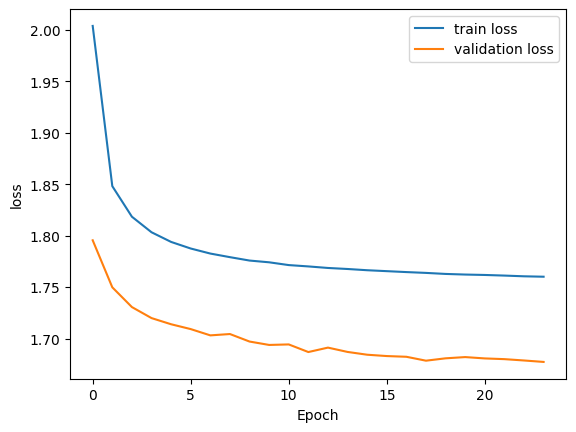

In [121]:
plt.plot(keyVals['loss'])
plt.plot(keyVals['val_loss'])
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

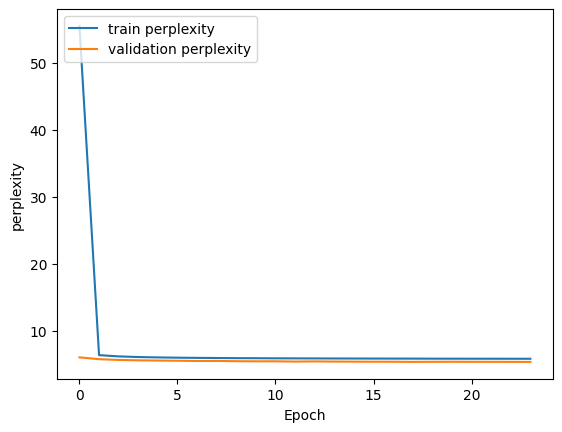

In [124]:
plt.plot(keyVals['perplexity'])
plt.plot(keyVals['val_perplexity'])
plt.ylabel('perplexity')
plt.xlabel('Epoch')
plt.legend(['train perplexity', 'validation perplexity'], loc='upper left')
plt.show()

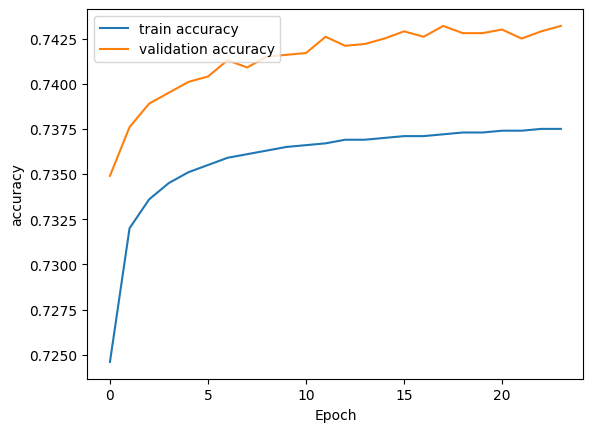

In [123]:
plt.plot(keyVals['accuracy'])
plt.plot(keyVals['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='upper left')
plt.show()

### Loading Best Saved Model 

In [14]:
loadModel = tf.keras.models.load_model('model2_save/weights-24-5.3944.hdf5',custom_objects = {'perplexity':perplexity})

In [15]:
def predictOutput(input_sentence):
    '''
    This Method returns the output sentence for given input sentence
    In this method we pass input sentence through all the layers in the model
    '''
    #Tokenizing input sentence
    enCode = bpemb_en.encode_ids_with_bos_eos(input_sentence)
    deSentence = [[1]]
    encInpTrain = pad_sequences([enCode], maxlen=15, padding="post")
    decoder_input_train = np.array(deSentence)
    embEncoder = loadModel.layers[1](encInpTrain)
    encOp,stateF,stateB=loadModel.layers[3](embEncoder)
    concatenated = loadModel.layers[5]([stateF,stateB])
    outputSentenceList = []
    for i in range(0,15):
        embeddingDec = loadModel.layers[4](decoder_input_train)
        output,state = loadModel.layers[6](embeddingDec, initial_state = concatenated)
        dense = loadModel.layers[8](output)
        dense1 = loadModel.layers[10](dense)
        index = np.argmax(dense1[0][0])
        deSentence = [[int(index)]]
        decoder_input_train = np.array(deSentence)
        outputSentenceList.append(int(index))
        concatenated = state
        if(index == 0):
              break
    return outputSentenceList

In [44]:
def returnOutput(listData):
    Predictions = []
    Lst = []
    for txt in tqdm(listData):
        Lst = bpemb_en.decode_ids(predictOutput(txt))
        Predictions.append(' '.join(Lst))
    return Predictions

returnOutput(['a copy of the ivaco','the forward price','paul should be able','thanks again for your','are you sure','here you go to','not the correct time to'])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.46it/s]


['is a copy of the agreement  ',
 'is a  ',
 'to get a copy of the attached  ',
 'help  ',
 'you are not  ',
 'the office  ',
 'be a good time  ']

In [16]:
Loss,Accuracy,Perplexity = loadModel.evaluate([encInpTest, decInpTest], decOutTest)
print('Loss:   ',Loss)
print('Accuracy:   ',Accuracy)
print('Perplexity:   ',Perplexity)

15435/15435 [==============================] - 483s 30ms/step - loss: 1.6776 - accuracy: 0.7431 - perplexity: 5.4514
Loss:    1.6775941848754883
Accuracy:    0.7431058883666992
Perplexity:    5.451447486877441
